### Question 1
Obtain Topic Models (K=10, 20, 50) for both datasets by running LDA and NMF methods; you can call libraries for both methods and dont have to use the ES index as source. For both LDA and NMF: print out for each topic the top 20 words (with probabilities)

The rest of of topic exercises and results are required only for the LDA topics:
- 20NG: how well the topics align with the 20NG label classes? This is not asking for a measurement, but rather for a visual inspection to determine what topics match well with what classes. Does this change if one increases the topics from 20 to 50?

In [1]:
### Importing required libraries and a bit more
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from jupyterthemes import jtplot

import umap
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [2]:
# set plot rc parameters

jtplot.style(grid=False)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#464646'
plt.rcParams['axes.edgecolor'] = '#FFFFFF'
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['text.color'] = '#666666'
plt.rcParams['axes.labelcolor'] = '#666666'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.color'] = '#666666'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.color'] = '#666666'
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['font.size'] = 16

sns.color_palette('dark')
%matplotlib inline

In [3]:
# Load news data set
# remove meta data headers footers and quotes from news dataset
dataset = fetch_20newsgroups(shuffle=True,
                            random_state=32,
                            remove=('headers', 'footers', 'quotes'))

Confirming news articles

In [4]:
# sneak peek of the news articles
for idx in range(3):
    print(dataset.data[idx][0:90],'\n\n','#'*100, '\n\n')

The real question here in my opinion is what Motorola processors running system
7 on a MAC 

 #################################################################################################### 


Please could someone in the US give me the current street 
prices on the following, with a 

 #################################################################################################### 


Can somebody please help me with information about an
American Magnetics Corporation Magst 

 #################################################################################################### 




In [5]:
# put your data into a dataframe
news_df = pd.DataFrame({'News': dataset.data,
                       'Target': dataset.target})

# get dimensions of data 
news_df.shape

(11314, 2)

In [6]:
news_df.head()

,News,Target
0,The real question here in my opinion is what M...,4
1,Please could someone in the US give me the cur...,4
2,Can somebody please help me with information a...,12
3,"\nI have already called senators, legislators ...",16
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7


Creating a new column for the news group topic name from the dataset and matching it to target category using a lambda function

In [7]:
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataset.target_names[x]) 
news_df.head()

,News,Target,Target_name
0,The real question here in my opinion is what M...,4,comp.sys.mac.hardware
1,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware
2,Can somebody please help me with information a...,12,sci.electronics
3,"\nI have already called senators, legislators ...",16,talk.politics.guns
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7,rec.autos


In [8]:
news_df['Target_name'].shape

(11314,)

Target name is the same shape as target, and we can use it to make a histogram plot using sns and inspect the true distribution of topics based on the number of documents associated with each topic.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'comp.sys.mac.hardware'),
  Text(1, 0, 'sci.electronics'),
  Text(2, 0, 'talk.politics.guns'),
  Text(3, 0, 'rec.autos'),
  Text(4, 0, 'rec.sport.baseball'),
  Text(5, 0, 'misc.forsale'),
  Text(6, 0, 'soc.religion.christian'),
  Text(7, 0, 'alt.atheism'),
  Text(8, 0, 'sci.space'),
  Text(9, 0, 'rec.motorcycles'),
  Text(10, 0, 'comp.graphics'),
  Text(11, 0, 'comp.sys.ibm.pc.hardware'),
  Text(12, 0, 'rec.sport.hockey'),
  Text(13, 0, 'comp.os.ms-windows.misc'),
  Text(14, 0, 'talk.politics.misc'),
  Text(15, 0, 'sci.crypt'),
  Text(16, 0, 'comp.windows.x'),
  Text(17, 0, 'talk.religion.misc'),
  Text(18, 0, 'sci.med'),
  Text(19, 0, 'talk.politics.mideast')])

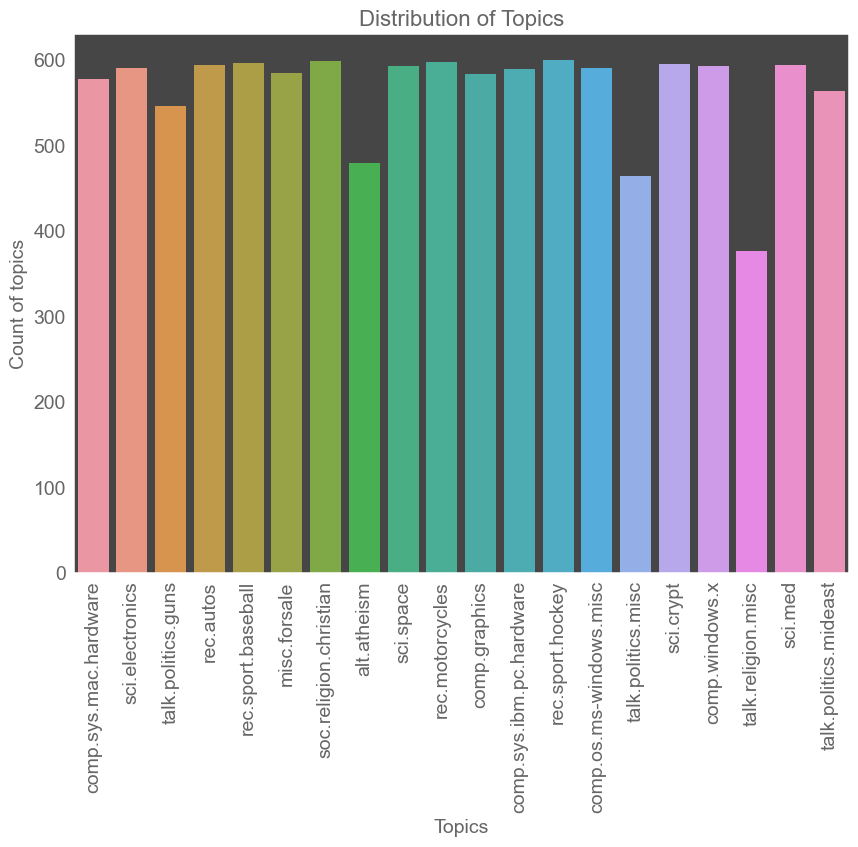

In [9]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(x=news_df['Target_name'])
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)

Now, lets clean the data

In [10]:
# clean text data
# remove non alphabetic characters
# remove stopwords and lemmatize
import string
def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = str.lower(pattern.sub(' ', sentence).strip())
    
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = set(stopwords.words('english'))
    # puctuation
    punct = set(string.punctuation)
    
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    # remove punctuation
    word_list = [word for word in word_list if word not in punct]
    
    # stemming
    ps  = PorterStemmer()
    word_list = [ps.stem(word) for word in word_list]
    
    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)
    
    return sentence

# we'll use tqdm to monitor progress of data cleaning process
# create tqdm for pandas
tqdm.pandas()
# clean text data
news_df['News'] = news_df['News'].progress_apply(lambda x: clean_text(str(x)))

100%|██████████| 11314/11314 [00:54<00:00, 209.26it/s]


Let's inspect the words in the articles now

In [11]:
news_df.head()

,News,Target,Target_name
0,real question opinion motorola processor run s...,4,comp.sys.mac.hardware
1,plea could someon give current street price fo...,4,comp.sys.mac.hardware
2,somebodi plea help inform american magnet corp...,12,sci.electronics
3,alreadi call senat legisl governor demand warr...,16,talk.politics.guns
4,articl news ysu edu yfn ysu edu john daker sur...,7,rec.autos


Now that we have just the words per target topics, let's create a word cloud

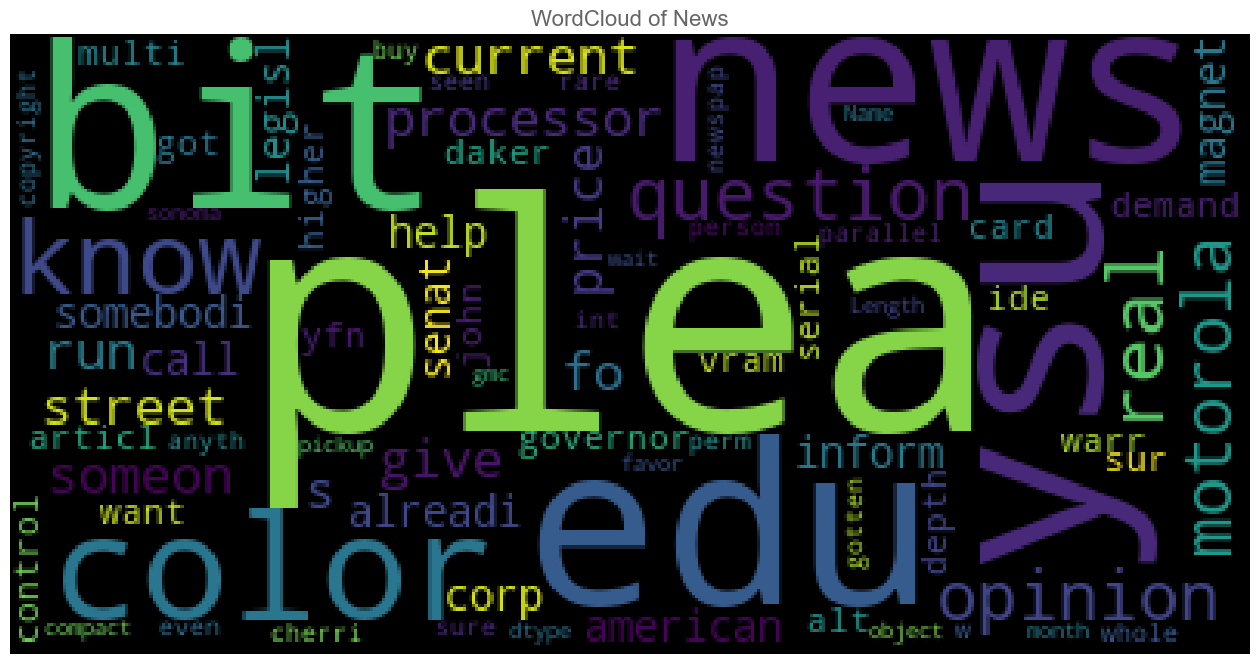

In [12]:
# plot word count for news text
wordcloud = WordCloud(background_color='black',
                      max_words=200).generate(str(news_df['News']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

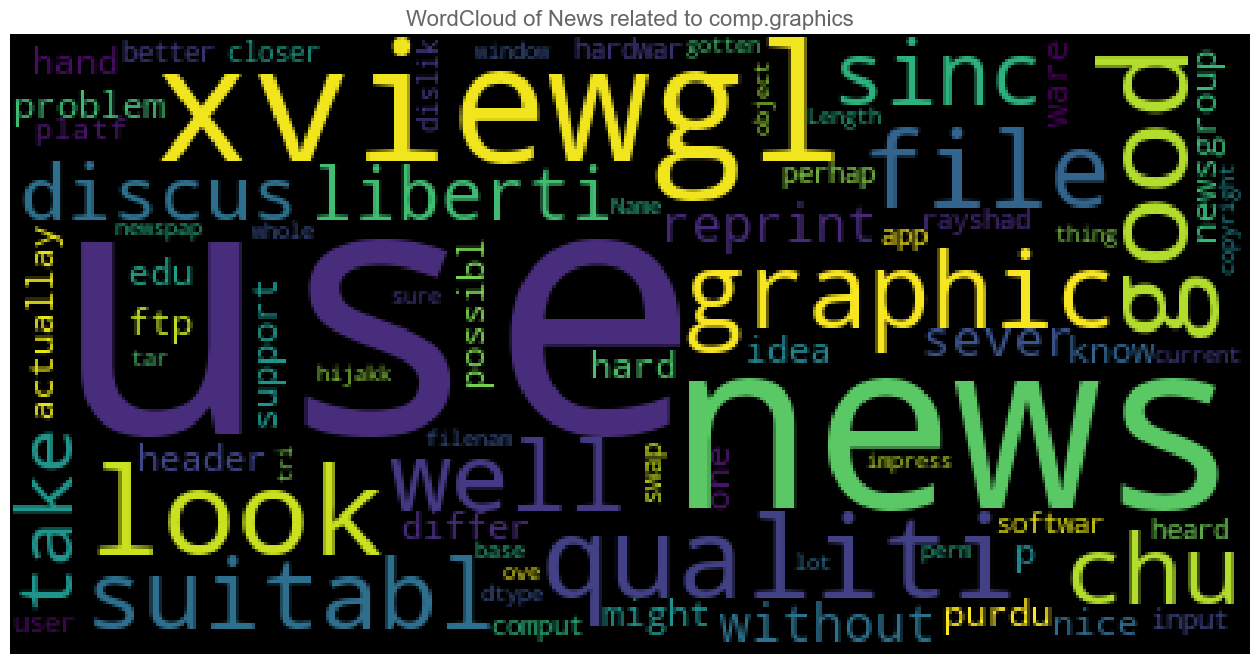

In [13]:

# plot word count for news text
wordcloud = WordCloud(background_color='black',
                      max_words=200).generate(str(news_df["News"][news_df["Target_name"] == "comp.graphics"]))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News related to comp.graphics')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

edu might be recurring because of the email addresses in the documents

Steps for Text Summarization covered till here
- Extract sentences [segment documents] 

And next we will cover: Apply Bag Of Words or LDA

In [14]:
#Step 1 TFiD vectorize the data
# vectorize text data
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split())
X = tfid_vec.fit_transform(news_df['News'])
X.shape

(11314, 55037)

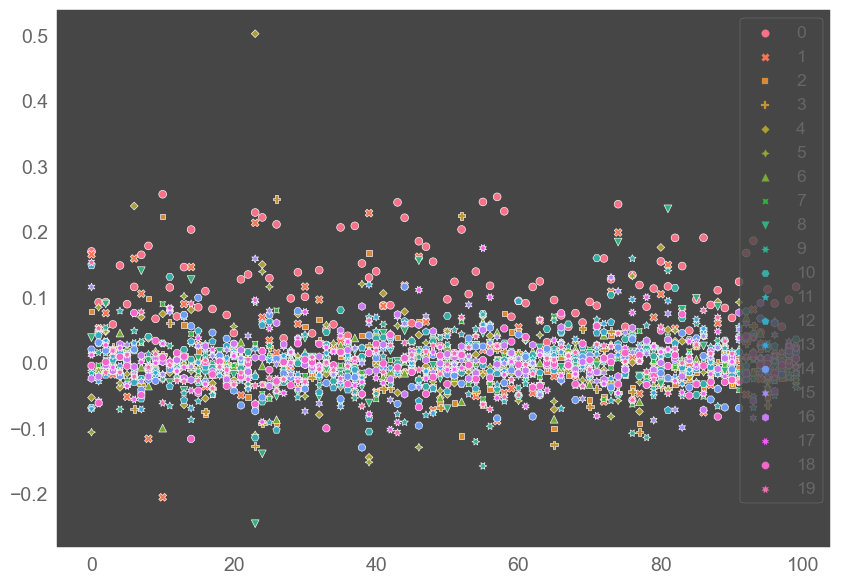

In [15]:
# Truncated SVD
tSVD = TruncatedSVD(n_components=20,
                         random_state=12,
                         n_iter=100,
                         algorithm='randomized')

# fit model to data
tSVD.fit(X)
X = tSVD.transform(X)
# plot news vectors
ax = sns.scatterplot(X[:100])
plt.show()

# pca doesn't take sparse input hence truncated SVD

In [16]:
terms = tfid_vec.get_feature_names()
len(terms)

d:\SoftwareSetups\Installations\Anaconda\envs\DMT\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


55037

In [17]:
# function to map words to topics
def map_word2topic(components, terms):
    # create output series
    word2topics = pd.Series()
    
    for idx, component in enumerate(components):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        word2topics['topic '+str(idx)+dataset.target_names[idx]] = list(term_topic.iloc[:10].index)
        
    return word2topics

In [18]:
word2topics = map_word2topic(tSVD.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics.index, word2topics):
    print(idx,'\t',item)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27820\4172869202.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word2topics = pd.Series()


Topics		Words
topic 0alt.atheism 	 ['would', 'one', 'use', 'get', 'like', 'know', 'peopl', 'think', 'time', 'say']
topic 1comp.graphics 	 ['window', 'file', 'drive', 'card', 'thank', 'use', 'do', 'driver', 'program', 'disk']
topic 2comp.os.ms-windows.misc 	 ['god', 'window', 'christian', 'jesu', 'file', 'bibl', 'believ', 'thank', 'faith', 'exist']
topic 3comp.sys.ibm.pc.hardware 	 ['key', 'encrypt', 'chip', 'use', 'clipper', 'secur', 'govern', 'escrow', 'law', 'system']
topic 4comp.sys.mac.hardware 	 ['drive', 'scsi', 'disk', 'card', 'god', 'hard', 'ide', 'floppi', 'control', 'bu']
topic 5comp.windows.x 	 ['thank', 'plea', 'mail', 'anyon', 'know', 'post', 'email', 'would', 'address', 'appreci']
topic 6misc.forsale 	 ['geb', 'dsl', 'cadr', 'jxp', 'chastiti', 'pitt', 'surrend', 'intellect', 'gordon', 'bank']
topic 7rec.autos 	 ['god', 'pitt', 'geb', 'cadr', 'dsl', 'chastiti', 'jxp', 'key', 'intellect', 'gordon']
topic 8rec.motorcycles 	 ['card', 'driver', 'video', 'monitor', 'color', 'bu

In [19]:
# topic word mapping martrix
tSVD.components_.shape

(20, 55037)

In [20]:
# document topic mapping matrix
doc_topic = tSVD.fit_transform(X)
doc_topic.shape

(11314, 20)

In [21]:
# get top3 topics for a news document
def get_top3_topics(x):
    top3 = list(x.sort_values(ascending=False).head(3).index) + list(x.sort_values(ascending=False).head(3).values)
    return top3

# map top3 topic words to news document
def map_topicword2doc(model, X):
    # output data frame column list
    cols = ['topic_'+str(i+1)+'_name' for i in range(3)] + ['topic_'+str(i+1)+'_prob' for i in range(3)]
    # doc to topic mapping
    doc_topic = model.fit_transform(X)
    # doc topic data frame
    doc_topic_df = pd.DataFrame(doc_topic, columns=dataset.target_names)
    # map top 3 topics to doc
    outdf = doc_topic_df.progress_apply(lambda x: get_top3_topics(x), axis=1)
    # outdf is a series of list
    # convert it to a data frame
    outdf = pd.DataFrame(dict(zip(outdf.index, outdf.values))).T
    outdf.columns = cols
    
    return outdf

In [22]:
top_topics = map_topicword2doc(tSVD, X)
news_topics = pd.concat([news_df, top_topics], axis=1)

100%|██████████| 11314/11314 [00:04<00:00, 2736.66it/s]


In [23]:
top_topics.shape, news_topics.shape

((11314, 6), (11314, 9))

In [24]:
# convert probability from string to float
news_topics = news_topics.infer_objects()

In [25]:
news_topics.head(10)

,News,Target,Target_name,topic_1_name,topic_2_name,topic_3_name,topic_1_prob,topic_2_prob,topic_3_prob
0,real question opinion motorola processor run s...,4,comp.sys.mac.hardware,alt.atheism,comp.graphics,talk.religion.misc,0.169485,0.164935,0.152539
1,plea could someon give current street price fo...,4,comp.sys.mac.hardware,alt.atheism,comp.windows.x,comp.graphics,0.091893,0.084124,0.052346
2,somebodi plea help inform american magnet corp...,12,sci.electronics,alt.atheism,rec.motorcycles,comp.graphics,0.092068,0.089142,0.075233
3,alreadi call senat legisl governor demand warr...,16,talk.politics.guns,alt.atheism,comp.sys.ibm.pc.hardware,soc.religion.christian,0.058055,0.023188,0.020212
4,articl news ysu edu yfn ysu edu john daker sur...,7,rec.autos,alt.atheism,sci.crypt,misc.forsale,0.147964,0.078535,0.044823
5,delet keep mind massachussett today patriot da...,9,rec.sport.baseball,alt.atheism,soc.religion.christian,misc.forsale,0.088898,0.026846,0.021694
6,use equip sale everyth negoti baud compuadd in...,6,misc.forsale,comp.sys.mac.hardware,comp.graphics,alt.atheism,0.238755,0.158625,0.115302
7,recent bought ram card origin mac portabl back...,4,comp.sys.mac.hardware,alt.atheism,rec.motorcycles,comp.graphics,0.164274,0.140015,0.104968
8,ye adamantli environmentalist use styrofoam ta...,15,soc.religion.christian,alt.atheism,comp.os.ms-windows.misc,rec.sport.hockey,0.177883,0.097813,0.039308
9,differ ozzi osbourn singer main charact black ...,15,soc.religion.christian,alt.atheism,talk.politics.misc,comp.windows.x,0.066648,0.032987,0.016951


Insted of Truncated SVD lets use Linear Dirichlet Allocation

In [26]:
#Step 1 TFiD vectorize the data
# vectorize text data
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split())
X = tfid_vec.fit_transform(news_df['News'])
X.shape

(11314, 55037)

In [27]:
# lda instance
lda_model = LatentDirichletAllocation(n_components=20,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50)
# fit model
lda_model.fit(X)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          max_iter=5, n_components=20, random_state=12)

In [28]:
lda_model.components_.shape


(20, 55037)

In [29]:
doc_topic_lda = lda_model.transform(X)
doc_topic_lda.shape

(11314, 20)

In [30]:
word2topics_lda = map_word2topic(lda_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics_lda.index, word2topics_lda):
    print(idx,'\t',item)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27820\4172869202.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word2topics = pd.Series()


Topics		Words
topic 0alt.atheism 	 ['wovi', 'yeager', 'io', 'rectum', 'curran', 'meaddata', 'mcrib', 'mcdalla', 'mcchicken', 'baio']
topic 1comp.graphics 	 ['rolex', 'niet', 'een', 'nile', 'meer', 'horlog', 'duidelijk', 'dit', 'sqrt', 'waldbronn']
topic 2comp.os.ms-windows.misc 	 ['max', 'haston', 'chz', 'bhj', 'giz', 'uww', 'utkvx', 'utk', 'skidmor', 'hijakk']
topic 3comp.sys.ibm.pc.hardware 	 ['ethan', 'jiann', 'getgeometri', 'upperleft', 'translatecoordin', 'cursor', 'polio', 'hover', 'amp', 'machin']
topic 4comp.sys.mac.hardware 	 ['wintrumpet', 'bilinski', 'winsock', 'arb', 'graphig', 'xmdrawingarea', 'glxmdraw', 'kuehnel', 'nicht', 'espoo']
topic 5comp.windows.x 	 ['pox', 'sktb', 'aohonj', 'pla', 'tthi', 'cnsider', 'staehl', 'brin', 'drexler', 'nonfict']
topic 6misc.forsale 	 ['geb', 'cadr', 'pitt', 'chastiti', 'jxp', 'dsl', 'intellect', 'surrend', 'gordon', 'shame']
topic 7rec.autos 	 ['mfc', 'yassin', 'manta', 'irgun', 'pneumonia', 'deir', 'erythromycin', 'kadett', 'slaught', '

### K = 50

In [31]:
# lda instance
lda_model = LatentDirichletAllocation(n_components=50,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50)
# fit model
lda_model.fit(X)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          max_iter=5, n_components=50, random_state=12)

In [32]:
lda_model.components_.shape


(50, 55037)

In [33]:
doc_topic_lda = lda_model.transform(X)
doc_topic_lda.shape

(11314, 50)

In [34]:

for idx, component in enumerate(lda_model.components_):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|t)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        print('topic '+str(idx)+' : '+ str(list(term_topic.iloc[:10].index)))


topic 0 : ['rectum', 'ru', 'baska', 'ordularinin', 'onemli', 'sehir', 'halk', 'kamilen', 'altina', 'bazi']
topic 1 : ['bootabl', 'wingert', 'medi', 'gallivan', 'blister', 'ubn', 'urepli', 'thn', 'pwoodcoc', 'unfortatun']
topic 2 : ['would', 'use', 'one', 'get', 'know', 'like', 'think', 'peopl', 'time', 'thank']
topic 3 : ['strait', 'jiann', 'aspartam', 'shrough', 'sweeten', 'groud', 'somekind', 'convini', 'pacman', 'methol']
topic 4 : ['vmode', 'snvt', 'maarten', 'bointon', 'trini', 'simm', 'vram', 'solder', 'expans', 'slot']
topic 5 : ['baldschun', 'schantz', 'boozer', 'roebuck', 'bun', 'mahaffey', 'cincinnati', 'bennett', 'short', 'cardin']
topic 6 : ['drl', 'koff', 'cruel', 'charon', 'usg', 'teleport', 'punish', 'gov', 'map', 'pain']
topic 7 : ['konstantinoupoli', 'chtm', 'instabul', 'qvgu', 'absol', 'infring', 'shirt', 'marek', 'brown', 'copyright']
topic 8 : ['pntr', 'sele', 'rawley', 'eastwick', 'delt', 'disp', 'osbourn', 'yloc', 'gcon', 'rootx']
topic 9 : ['ite', 'pivot', 'power

To me the 50 version doesn't make as much sense as the 20 one

### K = 10

In [35]:
# lda instance
lda_model = LatentDirichletAllocation(n_components=10,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50)
# fit model
lda_model.fit(X)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          max_iter=5, random_state=12)

In [36]:
lda_model.components_.shape


(10, 55037)

In [37]:
doc_topic_lda = lda_model.transform(X)
doc_topic_lda.shape

(11314, 10)

In [38]:

for idx, component in enumerate(lda_model.components_):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|t)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        print('topic '+str(idx)+' : '+ str(list(term_topic.iloc[:10].index)))


topic 0 : ['pneumonia', 'lavrenc', 'erythromycin', 'rectum', 'ljubljana', 'borut', 'ij', 'xgif', 'kuehnel', 'nicht']
topic 1 : ['nile', 'fervour', 'spectacl', 'mailread', 'networld', 'xelm', 'muzzah', 'va', 'melittin', 'nonononnononono']
topic 2 : ['wintrumpet', 'typhoon', 'syclon', 'mclain', 'spif', 'tre', 'vanecek', 'lumberjack', 'obbas', 'drayton']
topic 3 : ['max', 'haston', 'het', 'rolex', 'niet', 'giz', 'utkvx', 'bhj', 'utk', 'hijakk']
topic 4 : ['libxmu', 'xmu', 'bilinski', 'cockroach', 'ocunix', 'xrpc', 'fet', 'tesrt', 'ucblib', 'libtermcap']
topic 5 : ['feustel', 'myi', 'manta', 'uww', 'ethan', 'chz', 'kadett', 'gainesvil', 'scx', 'chigger']
topic 6 : ['winqvt', 'nen', 'curran', 'meaddata', 'frode', 'pntr', 'sele', 'critu', 'espoo', 'xgolf']
topic 7 : ['would', 'use', 'one', 'get', 'know', 'like', 'think', 'peopl', 'time', 'thank']
topic 8 : ['wovi', 'uhhhh', 'knbr', 'io', 'frisco', 'nead', 'ypu', 'rawley', 'eastwick', 'ru']
topic 9 : ['catbyt', 'dtmedin', 'ingr', 'iig', 'mfc'

In [39]:
from sklearn.decomposition import NMF 
nmf = NMF( n_components=10,  random_state=12,
                                     max_iter=5)

In [40]:
# fit model
nmf.fit(X)

d:\SoftwareSetups\Installations\Anaconda\envs\DMT\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn(


NMF(max_iter=5, n_components=10, random_state=12)

In [41]:
nmf.components_.shape

(10, 55037)

In [42]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(n_components//5, 5, figsize=(10*n_components//5, 15* n_components//5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

    plt.show()

In [43]:
from time import time
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(X)
print("done in %0.3fs." % (time() - t0))

done in 9.144s.


d:\SoftwareSetups\Installations\Anaconda\envs\DMT\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


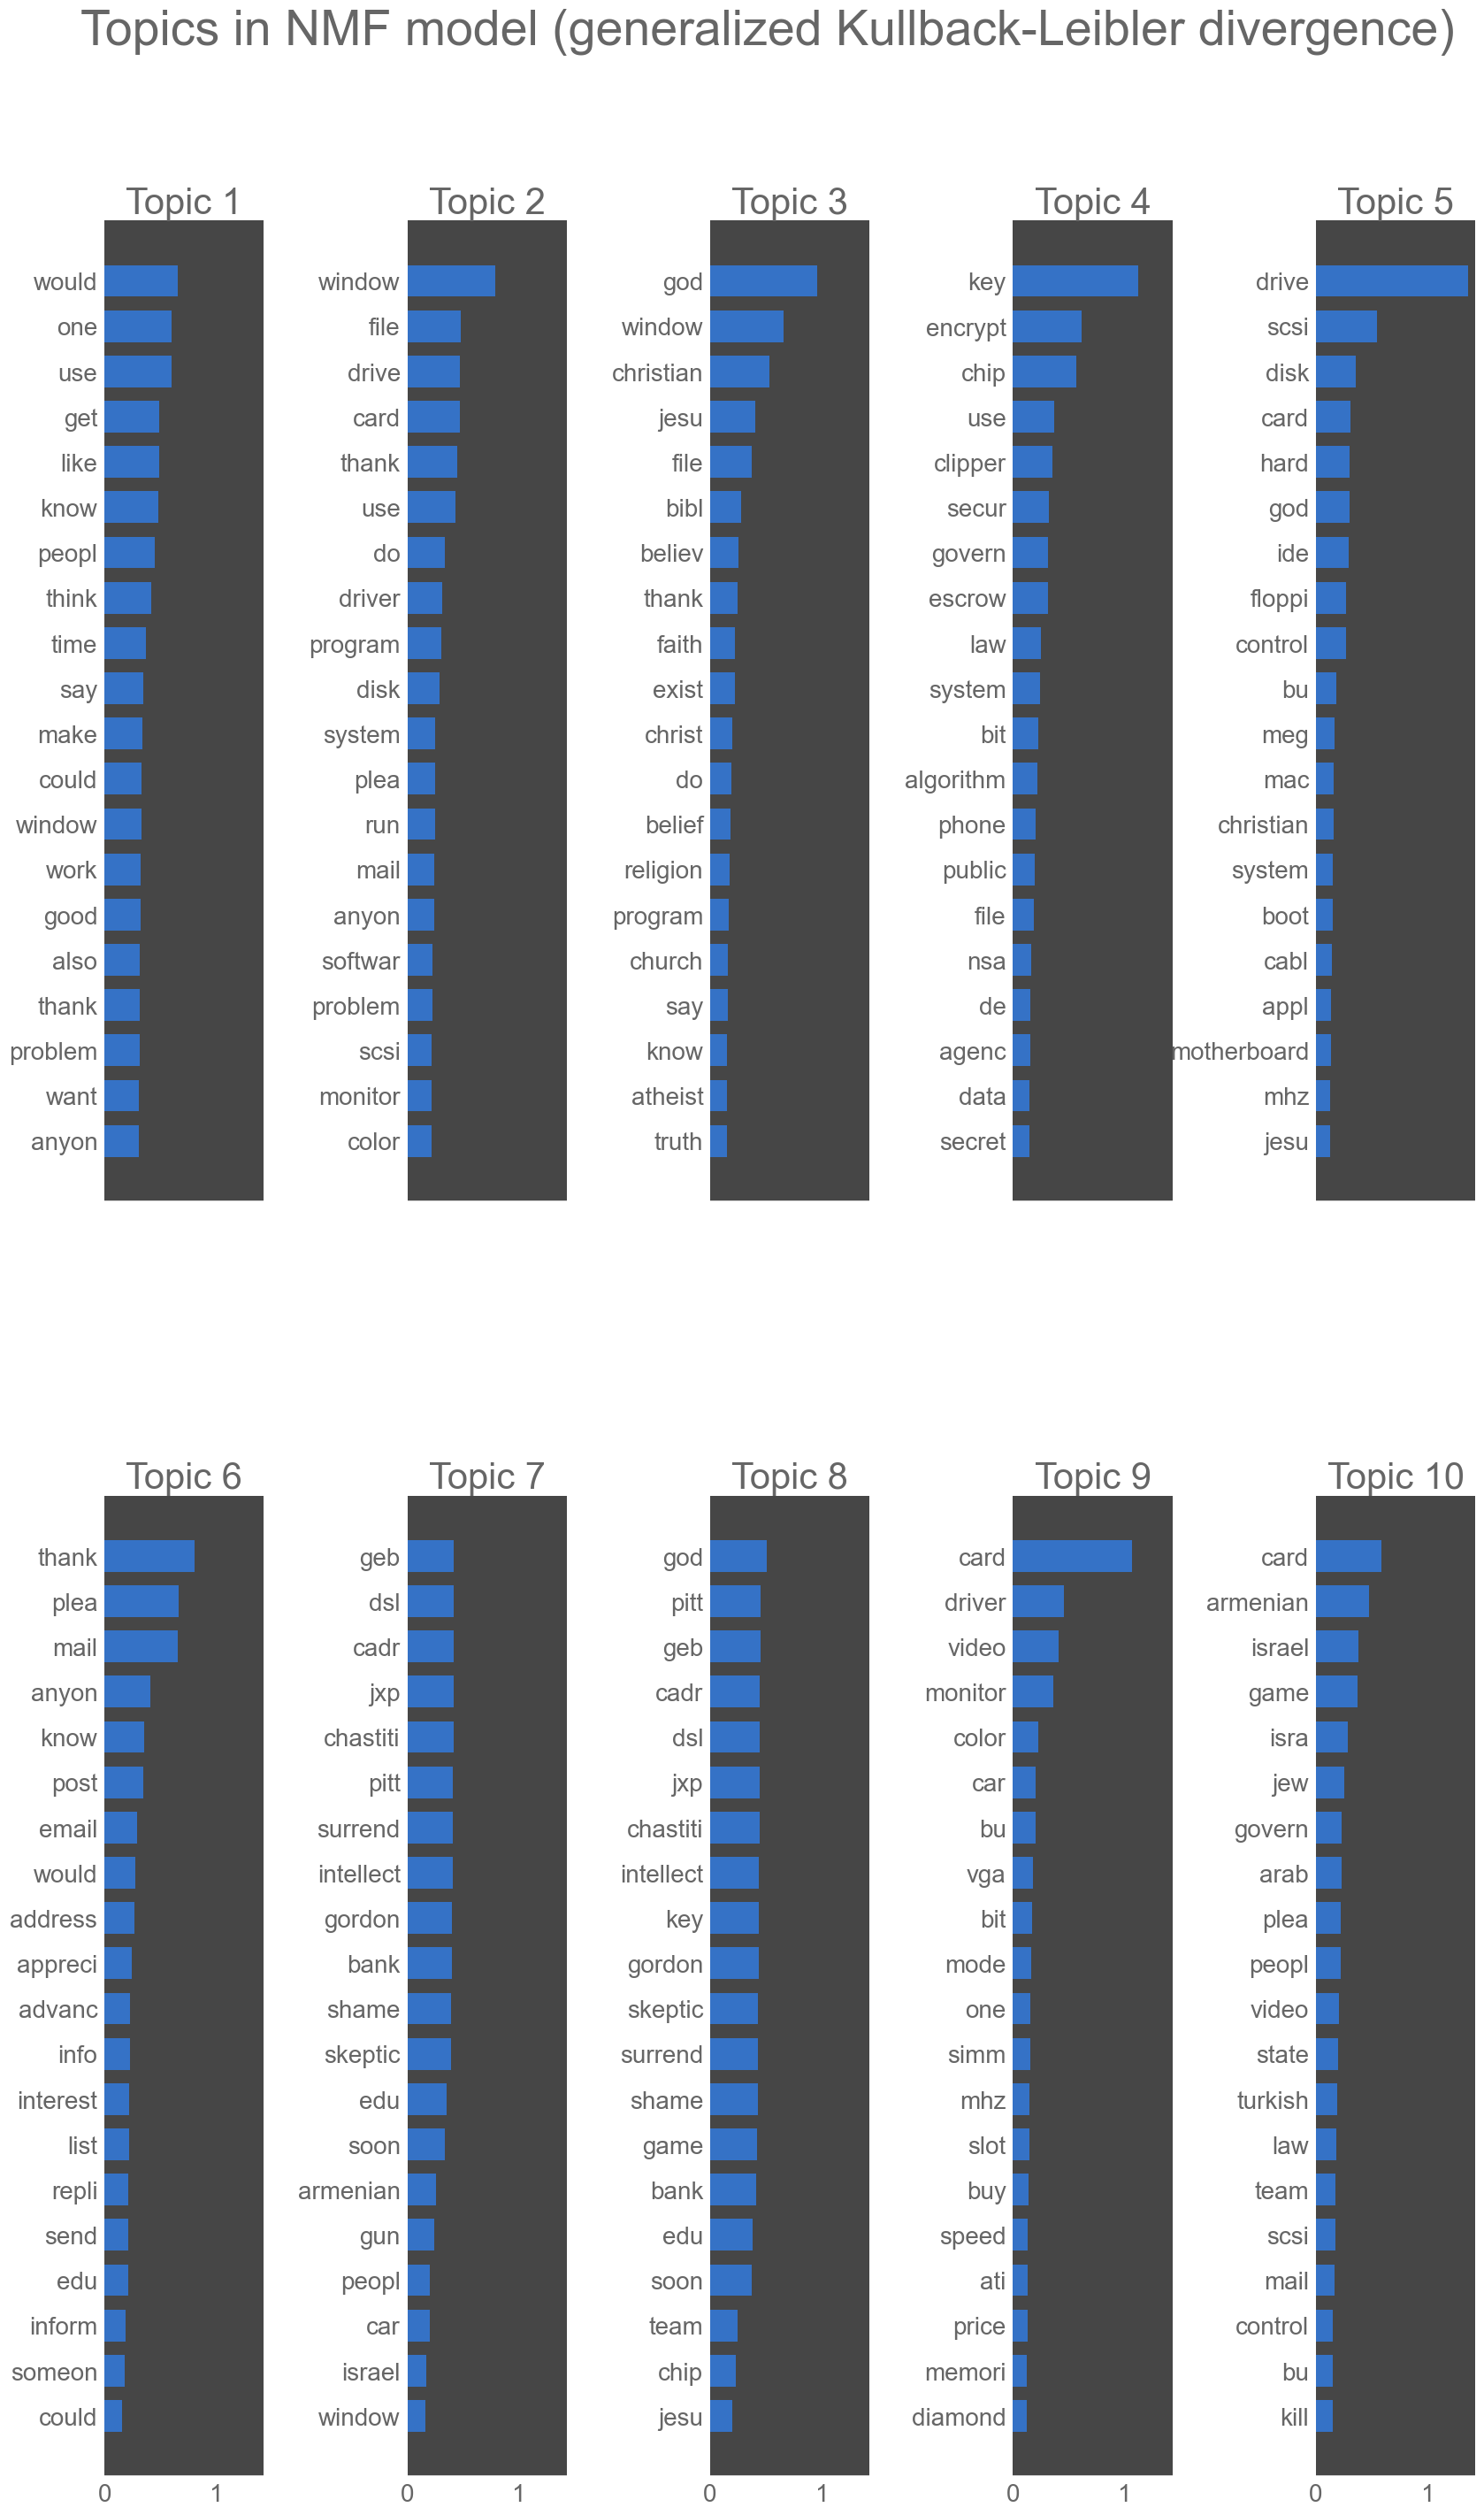

In [44]:
tfidf_feature_names = tfid_vec.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)


done in 1.251s.


 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...
done in 29.271s.


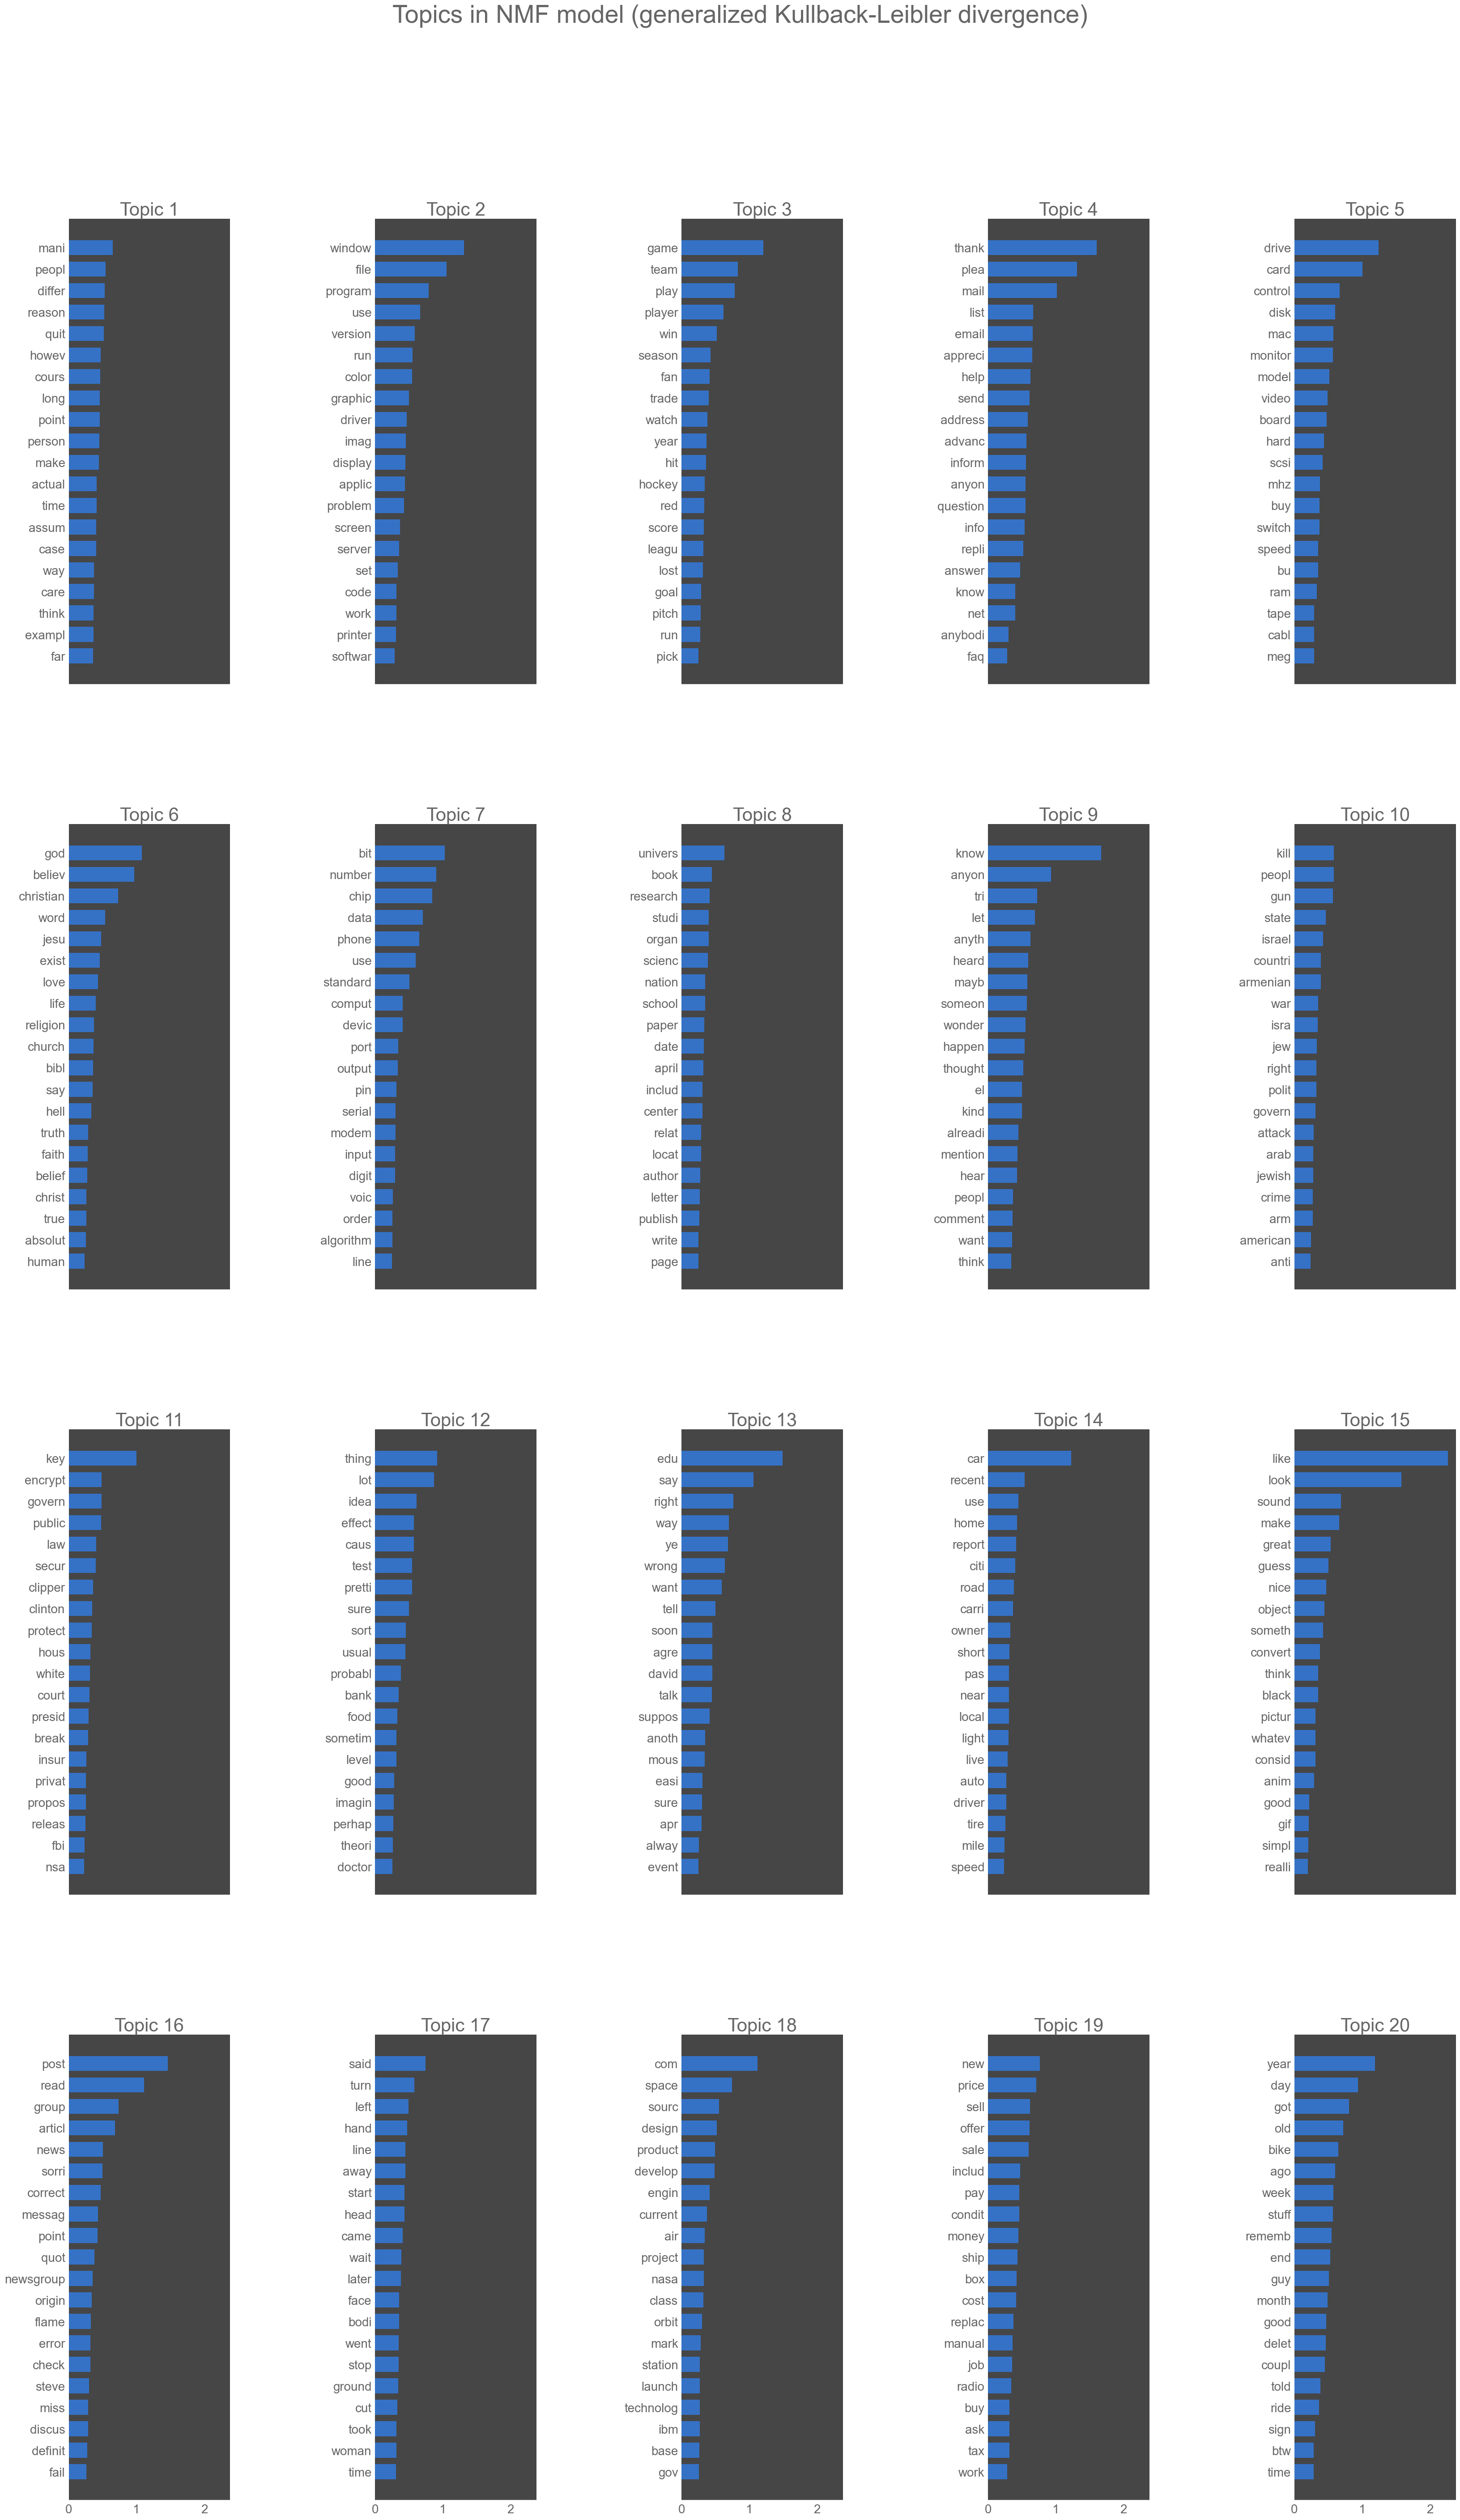

In [45]:
n_components = 20
from time import time
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(news_df['News'])
print("done in %0.3fs." % (time() - t0))
t0 = time()
# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)